In [1]:
import torch, os
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt


100%|██████████| 170498071/170498071 [00:05<00:00, 33244747.14it/s]


Extracting data/cifar-10-python.tar.gz to data/
Epoch [0/50], Batch [0/782], Generator Loss: 0.6394, Discriminator Loss: 0.7101
Epoch [0/50], Batch [100/782], Generator Loss: 0.7853, Discriminator Loss: 0.3515
Epoch [0/50], Batch [200/782], Generator Loss: 1.4252, Discriminator Loss: 0.2088
Epoch [0/50], Batch [300/782], Generator Loss: 3.2800, Discriminator Loss: 0.0962
Epoch [0/50], Batch [400/782], Generator Loss: 3.6950, Discriminator Loss: 0.1173
Epoch [0/50], Batch [500/782], Generator Loss: 4.1377, Discriminator Loss: 0.0491
Epoch [0/50], Batch [600/782], Generator Loss: 2.9564, Discriminator Loss: 0.0599
Epoch [0/50], Batch [700/782], Generator Loss: 2.1331, Discriminator Loss: 0.0846
Epoch [1/50], Batch [0/782], Generator Loss: 0.9559, Discriminator Loss: 0.2885
Epoch [1/50], Batch [100/782], Generator Loss: 1.1387, Discriminator Loss: 0.2509
Epoch [1/50], Batch [200/782], Generator Loss: 1.3258, Discriminator Loss: 0.2000
Epoch [1/50], Batch [300/782], Generator Loss: 1.5735,

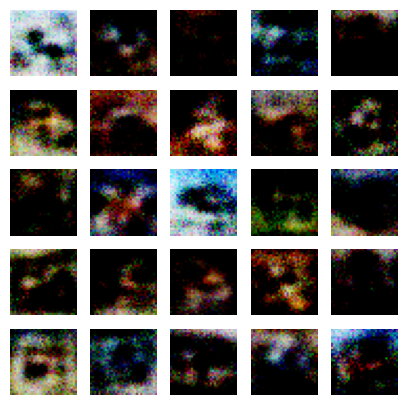

In [2]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 64
latent_size = 100
num_epochs = 50
lr = 0.0002

# CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CIFAR10(root='data/', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 3*32*32),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 3, 32, 32)
        return img

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3*32*32, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Initialize networks
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function and optimizer
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Training loop
for epoch in range(num_epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        # Adversarial ground truths
        valid = torch.ones(real_imgs.size(0), 1).to(device)
        fake = torch.zeros(real_imgs.size(0), 1).to(device)

        # Configure input
        real_imgs = real_imgs.to(device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(real_imgs.size(0), latent_size).to(device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Print progress
        if i % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}], Batch [{i}/{len(dataloader)}], "
                f"Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}"
            )

    # Save generated images
    if (epoch + 1) % 5 == 0:
        os.makedirs('gan_images', exist_ok=True)
        torchvision.utils.save_image(gen_imgs.data[:25], f"gan_images/{epoch + 1}.png", nrow=5, normalize=True)

# Generate and plot some images
generator.eval()
z = torch.randn(25, latent_size).to(device)
gen_imgs = generator(z)
gen_imgs = gen_imgs.cpu().detach()
plt.figure(figsize=(5, 5))
for i in range(gen_imgs.shape[0]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(gen_imgs[i].permute(1, 2, 0).numpy(), cmap='gray')
    plt.axis('off')
plt.show()
